<a href="https://colab.research.google.com/github/susmera-joseph/Disaster-Prediction/blob/master/VanilaTranformer370XAI2tsMule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install virtualenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 49.5 MB/s eta 0:00:00


In [ ]:
!virtualenv /content/drive/MyDrive/darts_env

created virtual environment CPython3.10.12.final.0-64 in 13095ms
  creator CPython3Posix(dest=/content/drive/MyDrive/darts_env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.3.1, setuptools==69.0.2, wheel==0.42.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [ ]:
!source /content/drive/MyDrive/darts_env/bin/activate; pip install darts python-docx

/bin/bash: /content/drive/MyDrive/darts_env/bin/pip: /content/drive/MyDrive/darts_env/bin/python: bad interpreter: Permission denied


In [ ]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0.post1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [ ]:
!nvidia-smi

Sat Feb 10 11:23:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                  N/A |
| N/A   33C    P0              24W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import sys
# add the path of the virtual environmentsite-packages to colab system path
sys.path.append("/content/drive/MyDrive/darts_env/lib/python3.10/site-packages")

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

#from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, ElectricityDataset

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
# Read data:
#series1 = AirPassengersDataset().load().astype(np.float32)
all_series = ElectricityDataset(multivariate=False).load()


100%|██████████| 370/370 [04:21<00:00,  1.41it/s]


In [ ]:
series=all_series[269]
#slpit="20141201"
slpit="201410191345"
#forecast_date="20141203"
forecast_date="201410201345"
# Create training and validation sets:
train, val = series.split_after(pd.Timestamp(slpit))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

In [ ]:
inl=96
ocl=2
epochs= 1
lrate = 1e-3
bs = 32
d_model=32
nhead=8
nel=2
ndl=2
dff=128
dropout=0.1
activation="relu"
my_model = TransformerModel(
    input_chunk_length=inl,
    output_chunk_length=ocl,
    batch_size=bs,
    n_epochs=epochs,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=nel,
    num_decoder_layers=ndl,
    dim_feedforward=dff,
    dropout=0.1,
    activation=activation,
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
    log_tensorboard=True,
    model_name="vanila_transformer",
    nr_epochs_val_period=10
)


In [ ]:
import time
start_time = time.time()
my_model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

end_time = time.time() # get the current time after executing the code
execution_time = end_time - start_time # calculate the time difference
print("Execution time: {:.6f} seconds to fit model  ".format(execution_time))
print("Execution time: {:.6f} hours to fit model  ".format(execution_time/(60*60)))


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Execution time: 382.441217 seconds to fit model  
Execution time: 0.106234 hours to fit model  


In [ ]:
TransformerModel.load_from_checkpoint( model_name="vanila_transformer", best=True)

FileNotFoundError: There is no file matching prefix best-* in /content/darts_logs/vanila_transformer/checkpoints

In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.saving.save_model(
    my_model, '/content/drive/MyDrive/saved_models', overwrite=False, save_format=None
)

AttributeError: 'TransformerModel' object has no attribute 'outputs'

Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 22.60%
<TimeSeries (DataArray) (date: 133302, component: 1, sample: 1)>
array([[[0.09375]],

       [[0.09375]],

       [[0.08125]],

       ...,

       [[0.55   ]],

       [[0.5375 ]],

       [[0.5    ]]])
Coordinates:
  * date       (date) datetime64[ns] 2011-01-01T00:15:00 ... 2014-10-20T13:30:00
  * component  (component) object 'power_usage'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


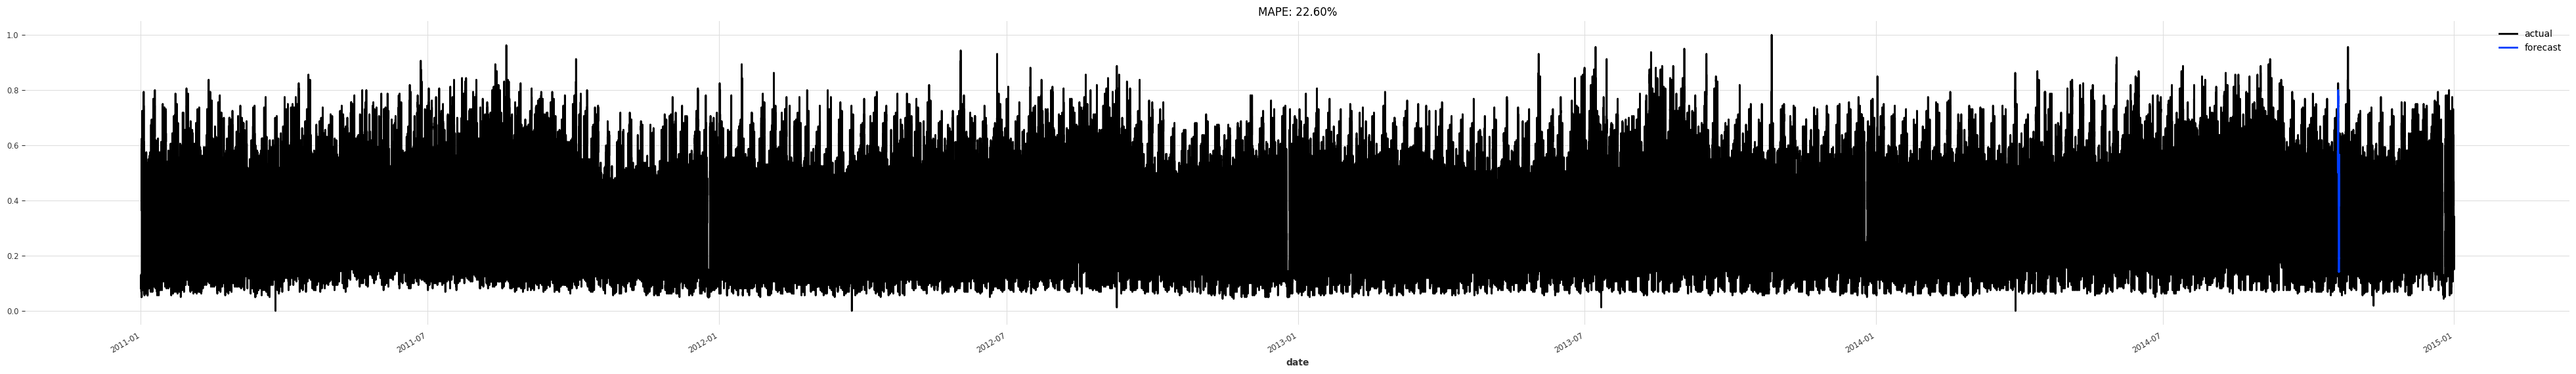

In [ ]:
mape_val =0.0
fh = 96
train_loss =0.00206
val_loss=0.00274
#fit_time = format(execution_time/(60*60))
env= 'colab'
fig_name = 'VT370'+'inl'+str(inl)+'ocl'+str(ocl)+'epochs'+str(epochs)+'lr'+str(lrate)+'bs'+str(bs)
#+'dm'+str(d_model)+'nh'+nhead+'nel'+str(nel)+'ndl'+str(ndl)+'dff'+str(dff)+'fh'+str(fh)+slpit

# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series,figsize1):
    pred_series = model.predict(n=n)
    #print(pred_series.end_time)
    plt.figure(figsize= figsize1)
    series.plot(label="actual")
    pred_series.plot(label="forecast")
    mape_val = mape(pred_series, val_series)
    #mse_val = np.square(np.subtract(pred_series, val_series)).mean()
    #mse_val = mse(pred_series, val_series)
    print("MAPE: {:.2f}%".format(mape_val))
    plt.title("MAPE: {:.2f}%".format(mape_val))
    plt.legend()
    filename1 = "FullFH"+str(n)+fig_name+".png"
    plt.savefig(filename1)
eval_model(my_model, fh, series_scaled, val_scaled, (50, 6))
series_toplot =series_scaled.drop_after(pd.Timestamp(forecast_date))
print(series_toplot)

In [ ]:
model_to_explain = TransformerModel.load_from_checkpoint("vanila_transformer")

FileNotFoundError: There is no file matching prefix best-* in /content/darts_logs/vanila_transformer/checkpoints

In [ ]:
from TSInterpret.InterpretabilityModels.Saliency.TSR import TSR
int_mod=TSR(my_model, train_scaled,train_scaled, method='IG',mode='time')
item= np.array([train_scaled[0,:,:]])
label=int(np.argmax(train_scaled[0]))

exp=int_mod.explain(item,labels=label,TSR =True)

%matplotlib inline
int_mod.plot(np.array([train_scaled[0,:,:]]),exp)

NotImplementedError: Please use a TF or PYT Classification model!                 If the current model is a TF or PYT Model,                 try calling the wrappers directly                 (TF -> Saliency_TF, PYT -> Saliency_PYT)

Predicting: |          | 0/? [00:00<?, ?it/s]

mape_val 11.741807357768037


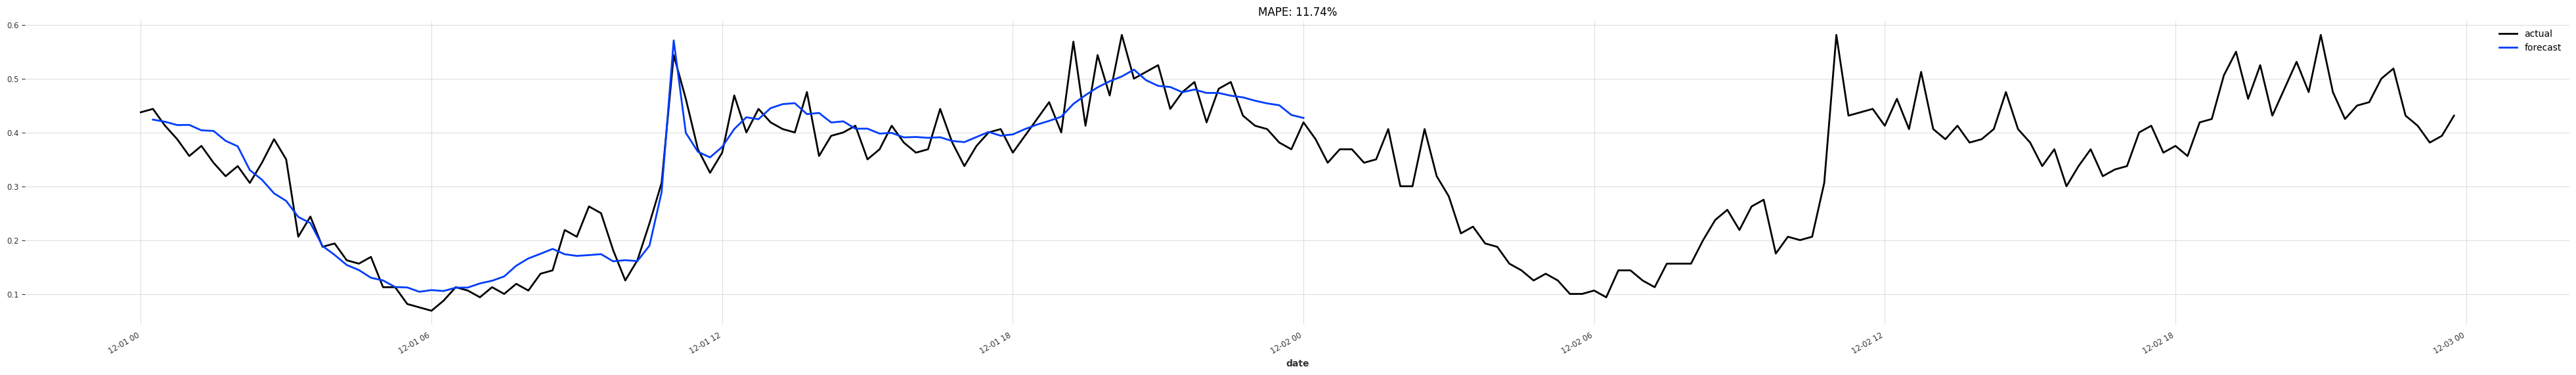

In [ ]:
filename2 = "FH"+str(fh)+fig_name+".png"
filename3 = "FH"+str(fh)+fig_name+"_bestmodel.png"
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series,figsize1,best):
    pred_series = model.predict(n=n)
    plt.figure(figsize= figsize1)
    series_toplot[-fh*2: ].plot(label="actual")
    pred_series.plot(label="forecast")
    mape_val = mape(pred_series, val_series)
    plt.title("MAPE: {:.2f}%".format(mape_val))
    plt.legend()
    if best:
        plt.savefig(filename3)
    else:
        plt.savefig(filename2)
    return mape_val
mape_val = eval_model(my_model, fh, series_scaled, val_scaled,(50, 6),False)
print("mape_val", mape_val)

Predicting: |          | 0/? [00:00<?, ?it/s]

best_mape 11.741807357768037   11.741807357768037 Boolean  True
same asEval model


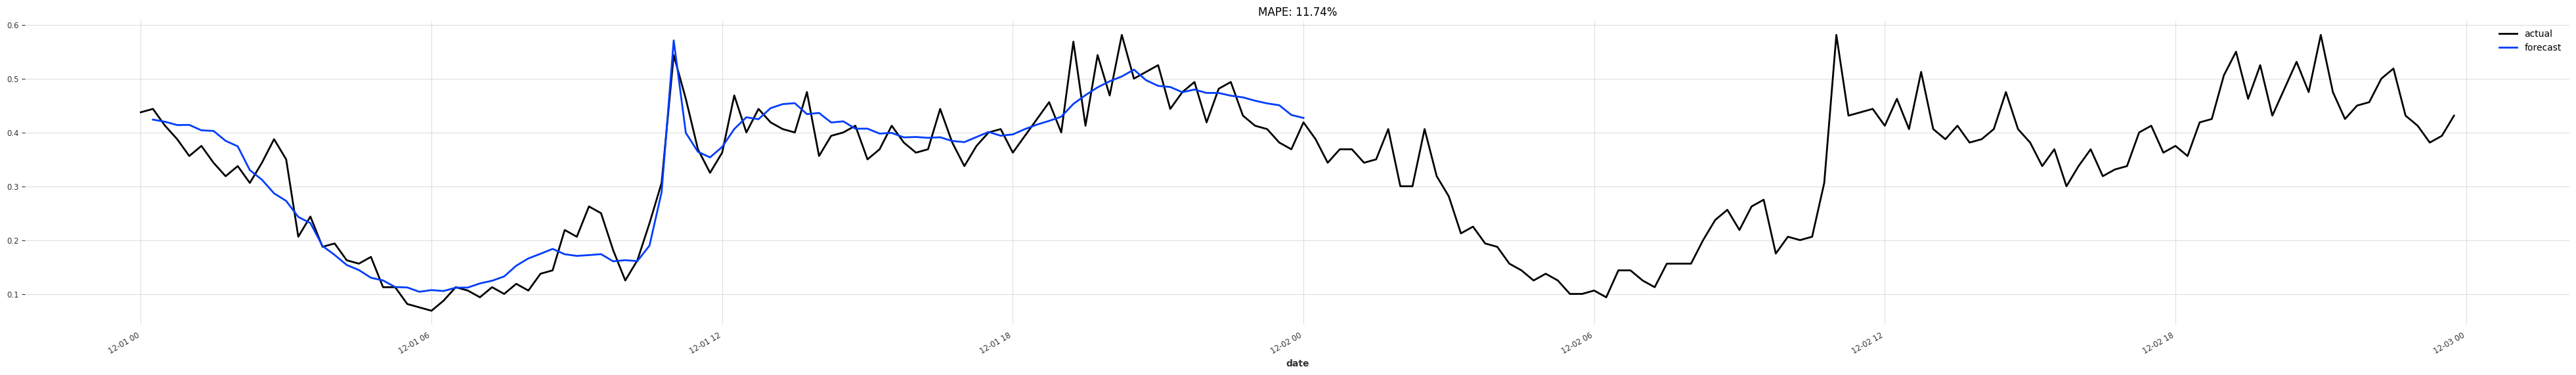

In [ ]:
best_model = TransformerModel.load_from_checkpoint(
    model_name="vanila_transformer", best=True
)
is_best = False
best_mape = eval_model(best_model, fh, series_scaled, val_scaled,(50, 6),is_best)
print("best_mape", best_mape ," ",mape_val , "Boolean ",best_mape==mape_val)
if best_mape != mape_val:
    is_best = True
    data = data+ "\n Best Model identified from check point best_mape = "+ str(best_mape)
    best_mape = eval_model(best_model, fh, series_scaled, val_scaled,(50, 6),True)
else:
    print("same asEval model")

In [ ]:
# Example usage
#doc_path = '' # for Jupyter notebook
data=''
doc_path ='/content/drive/MyDrive/'
doc_name = 'VT124.docx'
data = data +'\n MAPE' + str(mape_val)
print("data---",data)

data--- 
 MAPE11.741807357768037


In [ ]:
backtest_series = my_model.historical_forecasts(
    series=series_scaled,
    start=pd.Timestamp(slpit),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
backtest_mape = 0

backtest_mape 16.457886139013176
MAPE: 16.46%


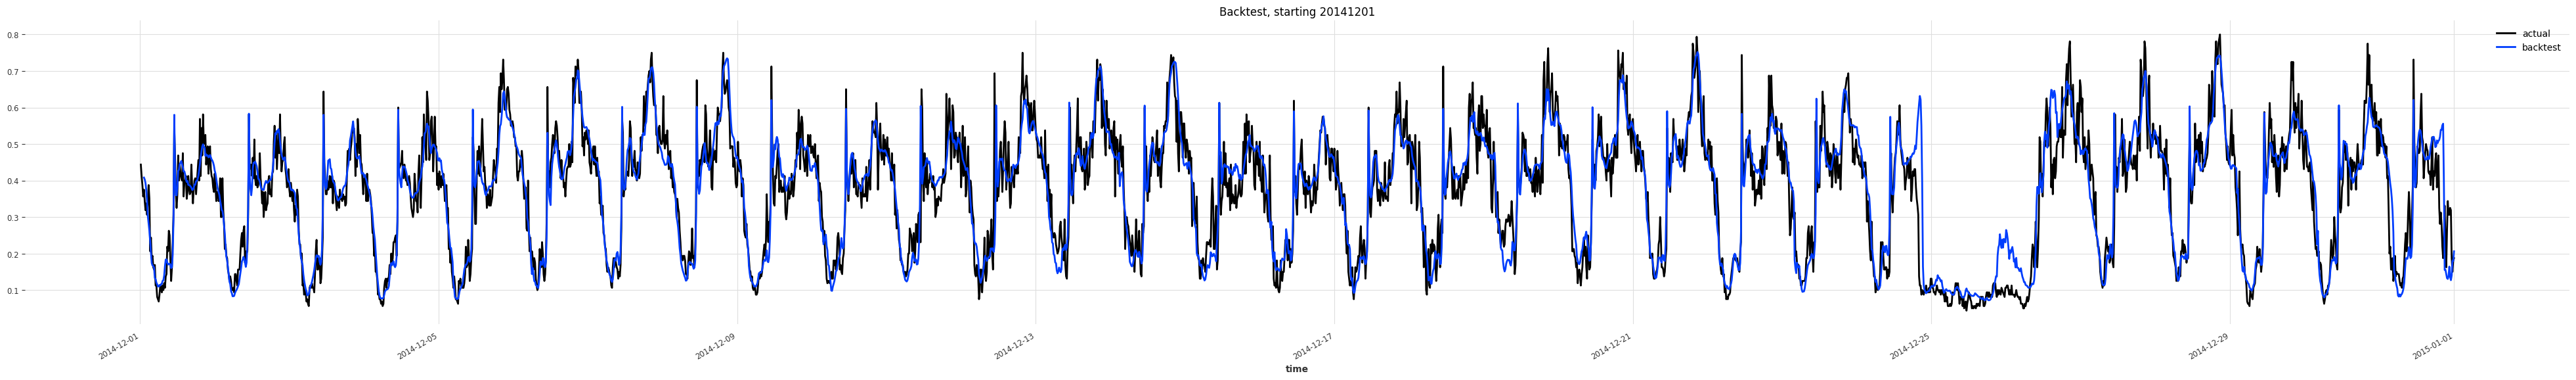

In [ ]:
backtest_mape = mape(
            scaler.inverse_transform(series_scaled),
            scaler.inverse_transform(backtest_series),
        )
print("backtest_mape" , backtest_mape)

filename4 = "FH"+str(fh)+fig_name+"BackTest.png"
data = data+ "\n backtest_mape"+ str(backtest_mape)
plt.figure(figsize=(50, 6))
series_scaled[-2976:].plot(label="actual", lw=2)
backtest_series.plot(label="backtest", lw=2)
plt.legend()
plt.title("Backtest, starting " +slpit)
plt.savefig(filename4)
print(
    "MAPE: {:.2f}%".format(backtest_mape)
)


In [ ]:
#!pip install python-docx

In [ ]:
# from docx import Document
# from docx.shared import Inches
# document = Document()
# paragraph = document.add_paragraph()
# paragraph.add_run('vt124')
# document.save('/content/drive/MyDrive/VT124.docx')

forecast_date 20141202


Predicting: |          | 0/? [00:00<?, ?it/s]

forecast_date 20141203


Predicting: |          | 0/? [00:00<?, ?it/s]

forecast_date 20141204


Predicting: |          | 0/? [00:00<?, ?it/s]

forecast_date 20141205


Predicting: |          | 0/? [00:00<?, ?it/s]

forecast_date 20141206


Predicting: |          | 0/? [00:00<?, ?it/s]

forecast_date 20141207


Predicting: |          | 0/? [00:00<?, ?it/s]

forecast_date 20141208


Predicting: |          | 0/? [00:00<?, ?it/s]

forecast_date 20141231


Predicting: |          | 0/? [00:00<?, ?it/s]

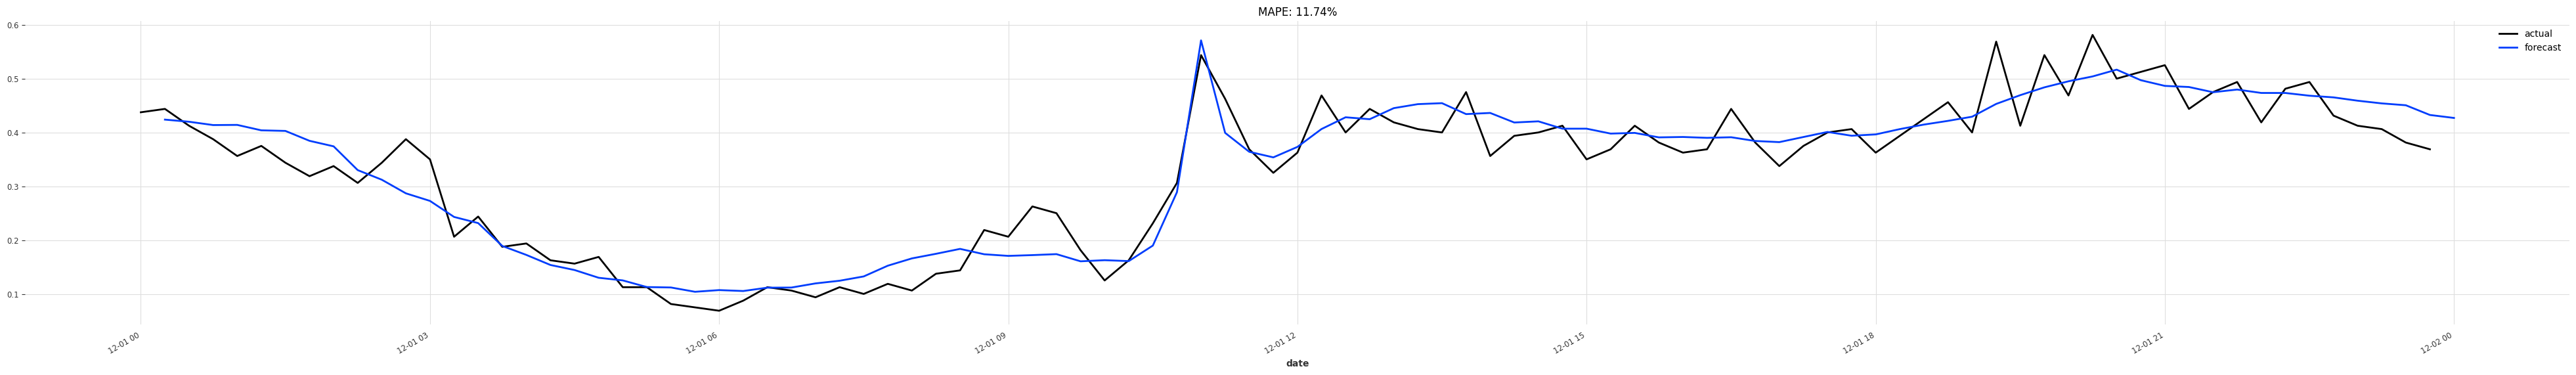

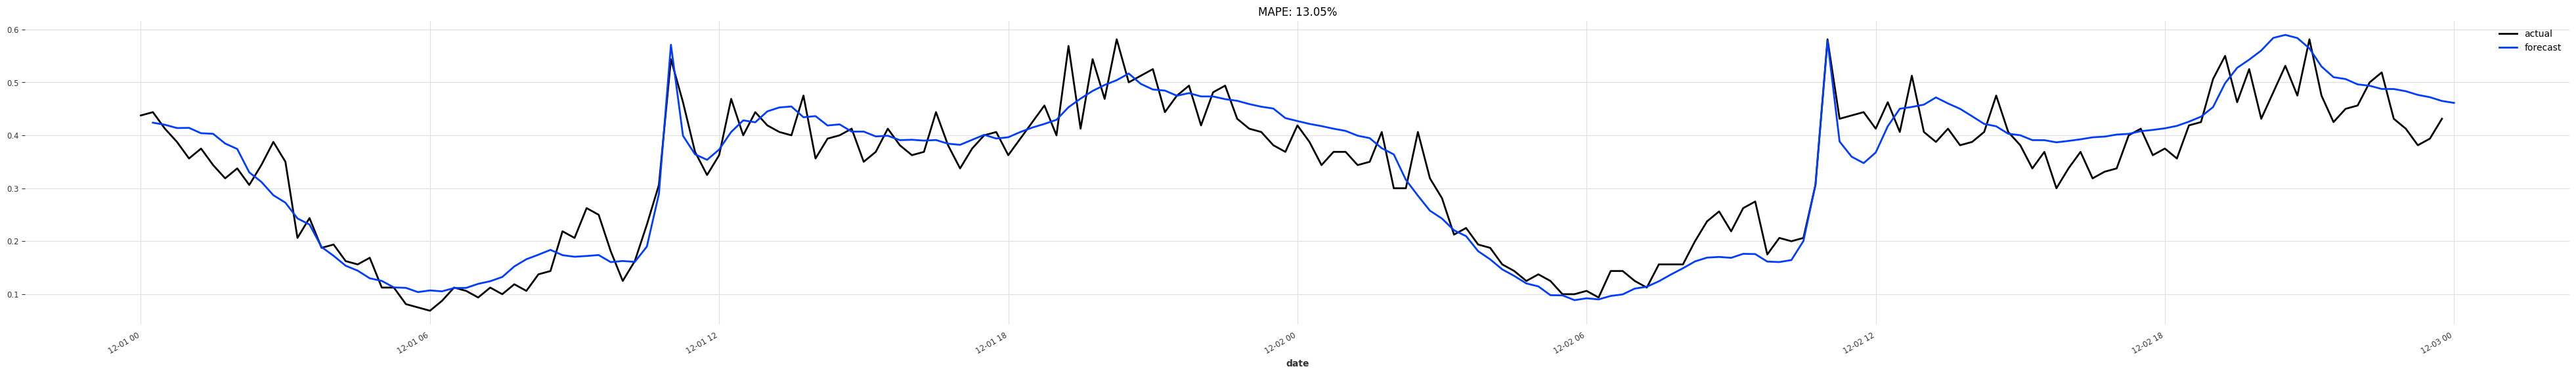

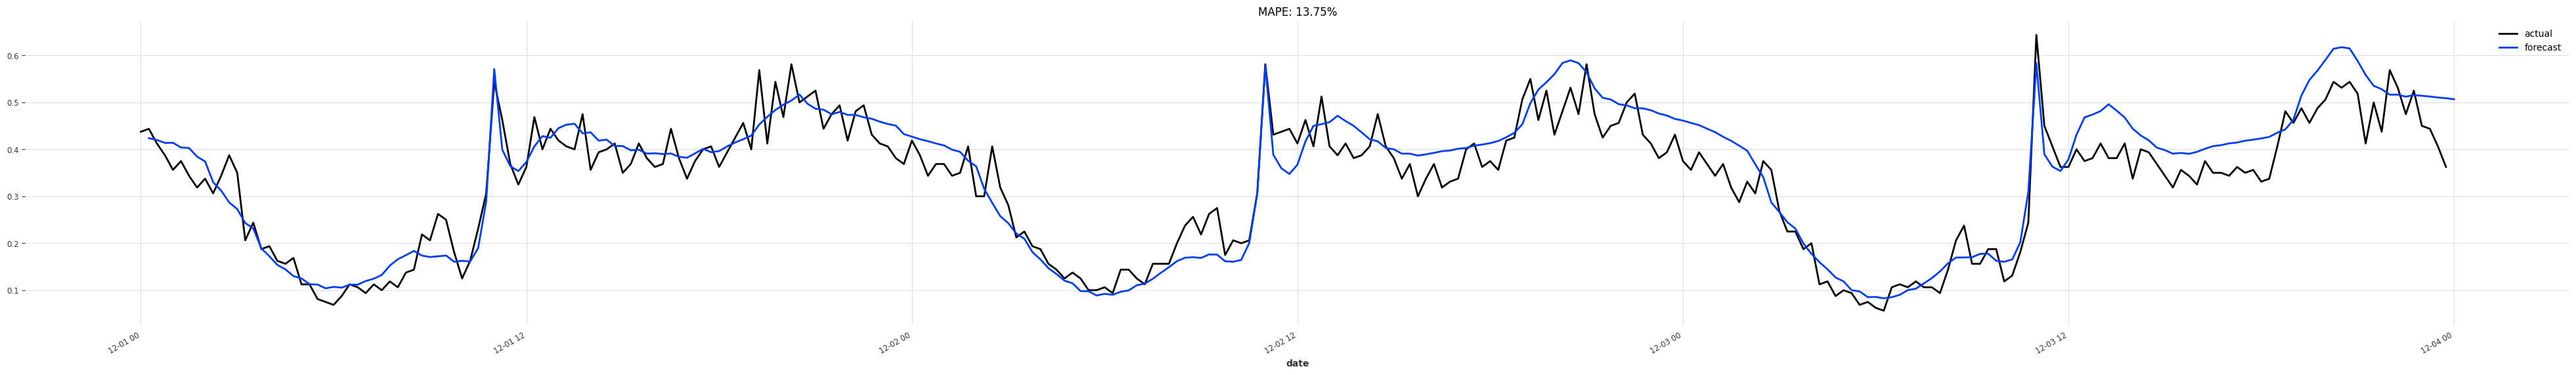

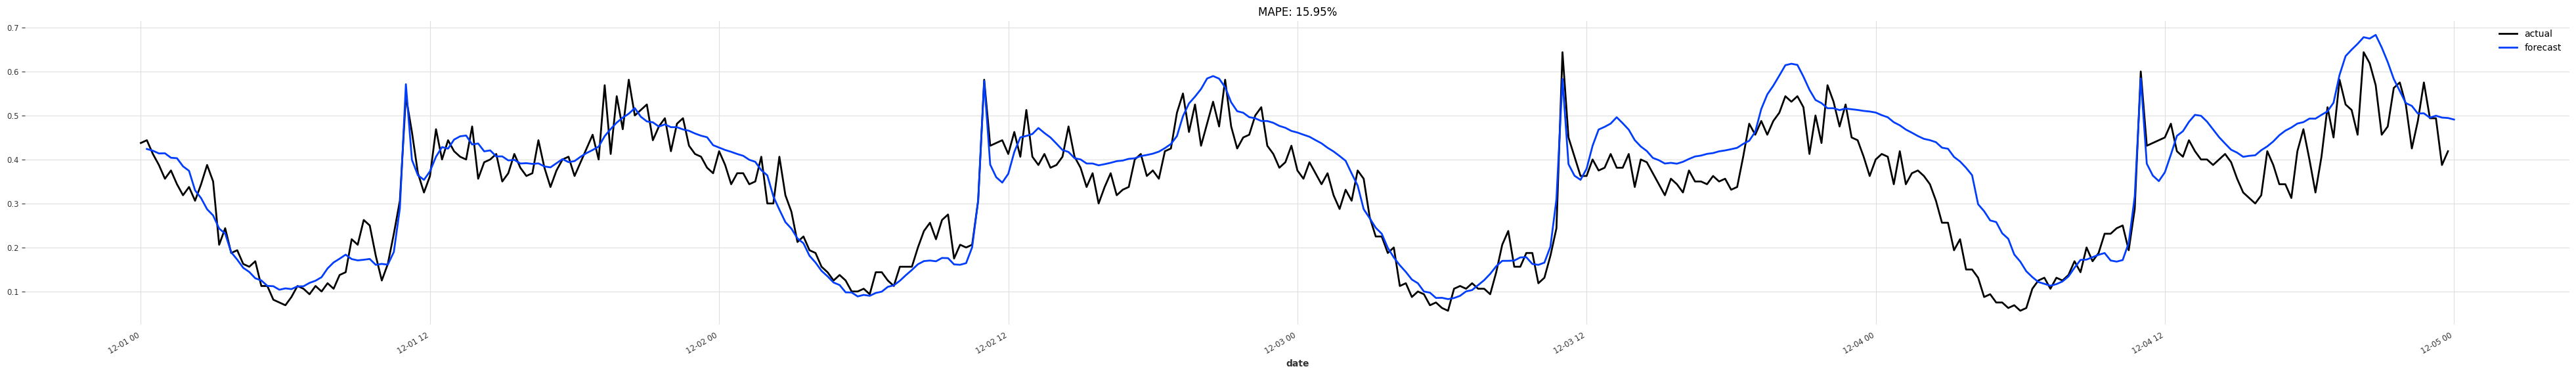

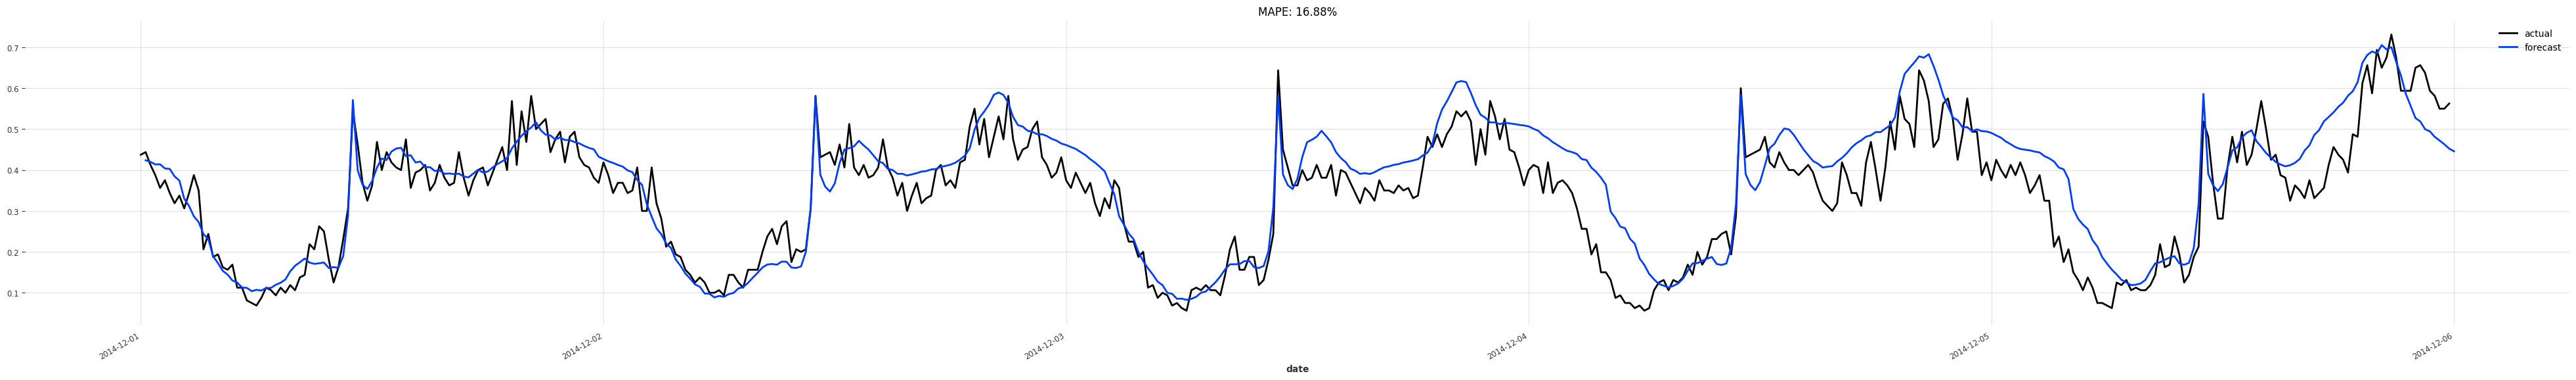

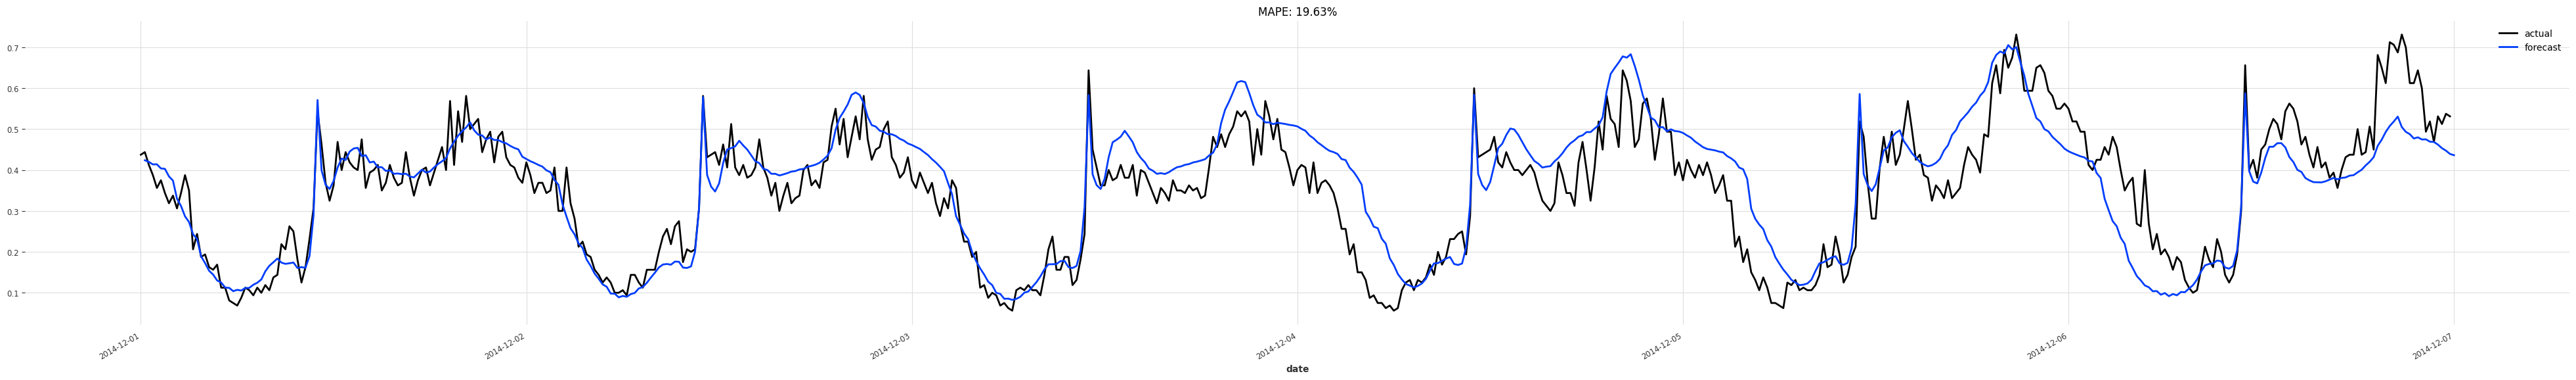

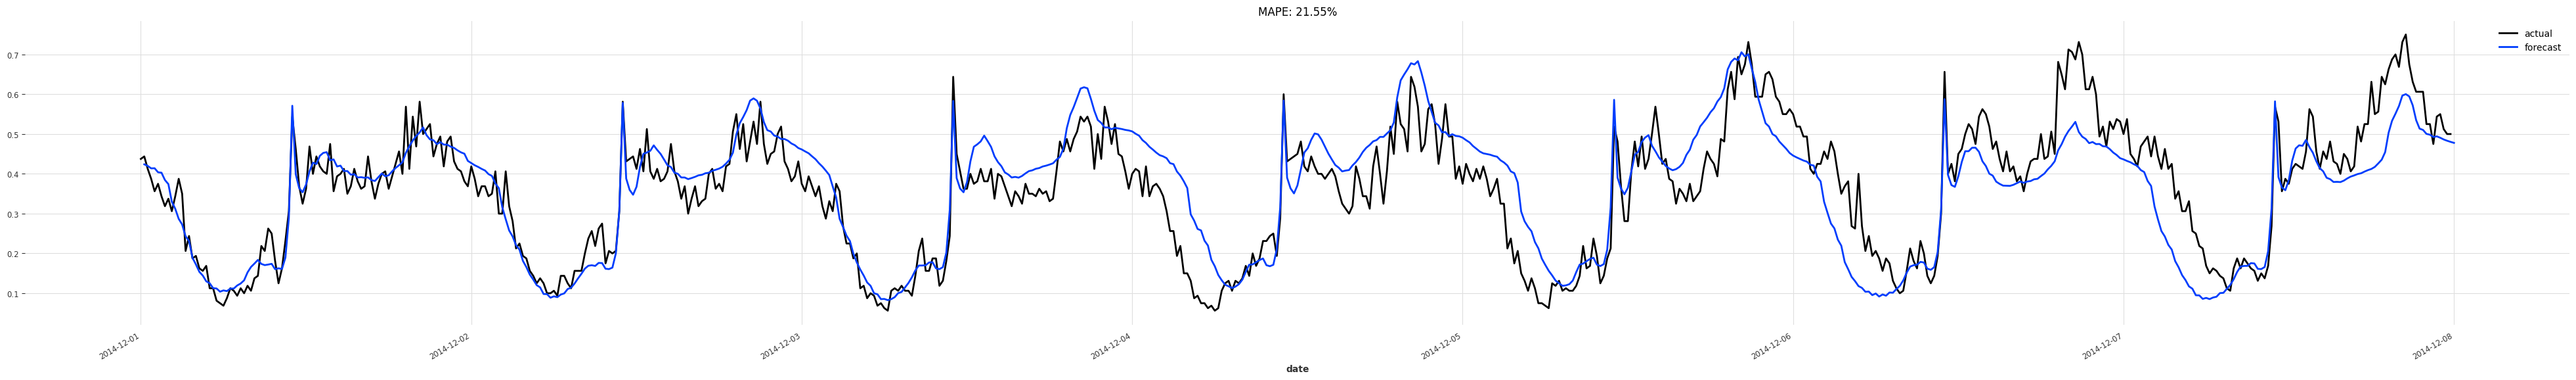

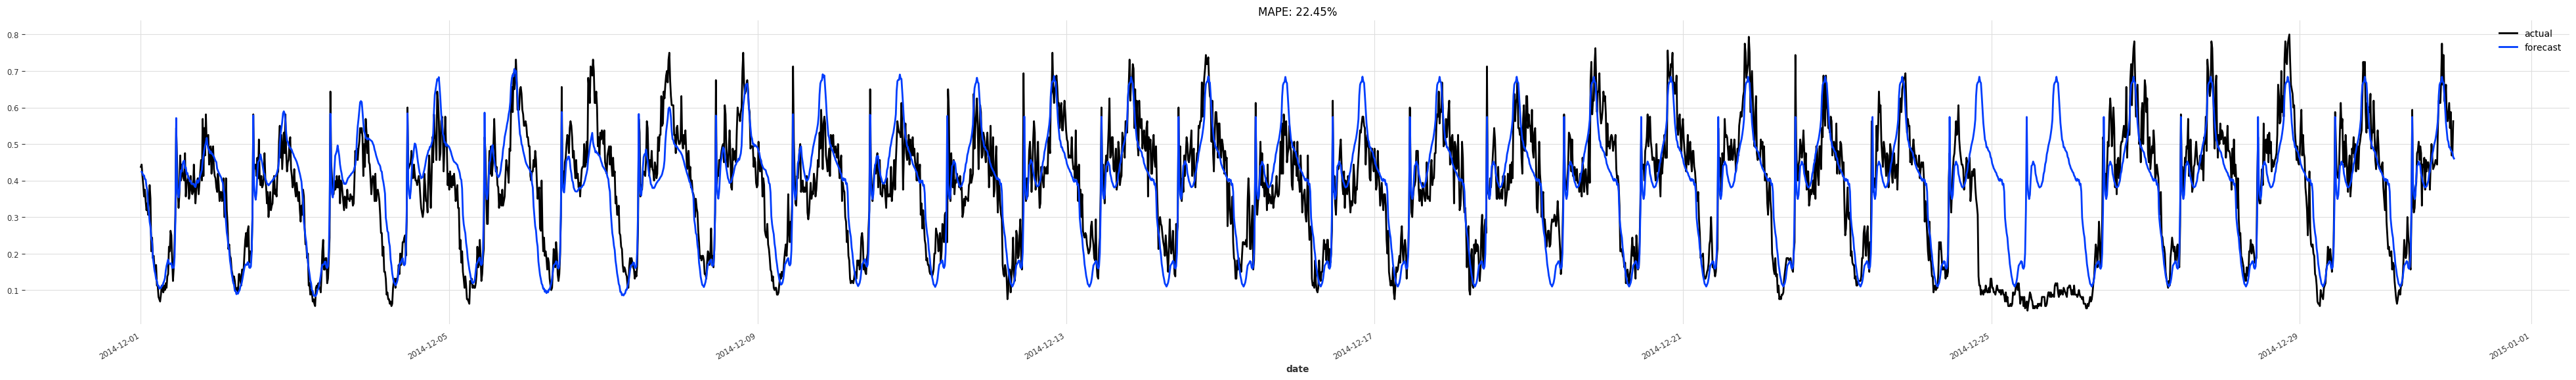

In [ ]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series,figsize1):
    pred_series = model.predict(n=n)
    plt.figure(figsize= figsize1)
    series_toplot[-fh: ].plot(label="actual")
    pred_series.plot(label="forecast")
    mape_valfh = mape(pred_series, val_series)
    plt.title("MAPE: {:.2f}%".format(mape_valfh))
    plt.legend()
    plt.savefig(filename2)
    return mape_valfh
date_value =20141201
list =[96, 192, 288,384, 480,576, 672,2880]
for fh in list:
    data2 =""
    only_fh = True
    filename3 = ''
    if fh == 2880:
        date_value= 20141231
    else:
        date_value= date_value +1
    forecast_date=str(date_value)
    print("forecast_date",forecast_date)
    series_toplot =series_scaled.drop_after(pd.Timestamp(forecast_date))
    mape_valfh = eval_model(my_model, fh, series_scaled, val_scaled,(50, 6))
    data2 = data2 + "Forecast horizon "+ str(fh)+ "mape_valfh " + str(mape_valfh)
    append_to_document(doc_path+ doc_name, data2)




In [ ]:
print("Execution time: {:.6f} hours to complete model  ".format(execution_time/(60*60)))

In [ ]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series,figsize1):
    pred_series = model.predict(n=n)
    plt.figure(figsize= figsize1)
    series[-96*62: ].plot(label="actual")
    pred_series.plot(label="forecast")
    mape_val = mape(pred_series, val_series)
    plt.title("MAPE: {:.2f}%".format(mape_val))
    plt.legend()
    plt.savefig("FH"+str(n)+fig_name+".png")
eval_model(my_model, fh, series_scaled, val_scaled,(50, 6))

In [ ]:
best_model = TransformerModel.load_from_checkpoint(
    model_name="vanila_transformer", best=True
)
eval_model(best_model, 96, series_scaled, val_scaled,(50, 6))

In [ ]:
from docx import Document
from docx.shared import Inches

In [ ]:
from docx import Document
from docx.shared import Inches
def append_to_document(file_name, data):
  """
  Appends data to an existing docx file.

  Args:
    file_name: The name of the docx file.
    data: A list of strings to be appended.
  """

  # Open the document
  document = Document(file_name)

  # Get the last paragraph
  last_paragraph = document.paragraphs[-1]
# Append the data to the last paragraph
      #for item in data:
  last_paragraph.add_run(data)
  #last_paragraph.add_run().add_picture(filename1, width=Inches(10))

  # Insert the image in colab
  #last_paragraph.add_run().add_picture("/content/"+filename2, width=Inches(10))
  #last_paragraph.add_run().add_picture("/content/"+filename3, width=Inches(10))
  #Insert the image in jupyter
  if only_fh:
      last_paragraph.add_run().add_picture(filename2, width=Inches(10))
  else:


      if filename3 != '':
        last_paragraph.add_run().add_picture(filename3, width=Inches(10))
      last_paragraph.add_run().add_picture(filename4, width=Inches(10))
      # Add a table to the document
      table = document.add_table(rows=1, cols=15)
      table_head = document.add_table(rows=1, cols=15)
      # Set the table style
      table.style = 'TableGrid'
      table_head.style = 'TableGrid'

      # Set column widths
      table.columns[0].width = Inches(0.5)
      table.columns[1].width = Inches(0.5)
      table.columns[2].width = Inches(1)
      table.columns[3].width = Inches(1)
      table.columns[4].width = Inches(0.5)
      table.columns[5].width = Inches(1)
      table.columns[6].width = Inches(1)
      table.columns[7].width = Inches(0.5)
      table.columns[8].width = Inches(0.5)
      table.columns[9].width = Inches(1)
      table.columns[10].width = Inches(1)
      table.columns[11].width = Inches(1)
      table.columns[12].width = Inches(1)
      table.columns[13].width = Inches(1)
      table.columns[14].width = Inches(1)
      # Add data to the table
      data = {
          "d_model": d_model,
          "nhead": nhead,
          "dff": dff,
          "inl": inl,
          "ocl": ocl,
          "epochs": epochs,
          "lrate": lrate,
          "train_loss": train_loss,
          "val_loss": val_loss,
          "valMAPE": mape_val,
          "BTMape": backtest_mape,
          "bs": bs,
          "split": slpit,
          "fit_time" :fit_time,
          "env": env
      }
      for i, (key, value) in enumerate(data.items()):
          table_head.cell(0, i).text = str(key)
      for i, (key, value) in enumerate(data.items()):
          table.cell(0, i).text = str(value)

  # Add a page break
  document.add_page_break()
  # Save the document
  document.save(file_name)


append_to_document(doc_path+ doc_name, data)